<a href="https://colab.research.google.com/github/beverleyappiatse/HayRajBev/blob/main/SMSSpamModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("SMSSpamCollection.csv", encoding='latin-1', header=None, names=['label', 'message'])

Saving SMSSpamCollection.csv to SMSSpamCollection.csv


In [3]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ã¼ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
# Core
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

from scipy import sparse


In [5]:
# Light cleanup (keeps your df intact otherwise)
df = df.copy()
df["label"]   = df["label"].str.strip().str.lower()
df["message"] = df["message"].astype(str).str.strip()
df = df.drop_duplicates().reset_index(drop=True)

# Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    df[["message"]], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)

y_train.value_counts(), y_test.value_counts()


(label
 ham     3612
 spam     514
 Name: count, dtype: int64,
 label
 ham     904
 spam    128
 Name: count, dtype: int64)

In [6]:
# Helper regex
link_pattern   = re.compile(r"(http[s]?://|www\.)", flags=re.IGNORECASE)
number_pattern = re.compile(r"\d")

def count_punct(s): return sum(ch in string.punctuation for ch in s)
def count_upper(s): return sum(ch.isupper() for ch in s)
def safe_ratio(num, den): return (num / den) if den else 0.0

def numeric_feature_frame(series: pd.Series) -> pd.DataFrame:
    lens  = series.str.len()
    words = series.str.split().apply(len)
    puncs = series.apply(count_punct)
    upp   = series.apply(count_upper)
    has_link   = series.apply(lambda s: 1 if link_pattern.search(s) else 0)
    has_number = series.apply(lambda s: 1 if number_pattern.search(s) else 0)
    return pd.DataFrame({
        "message_length": lens.astype(int),
        "word_count": words.astype(int),
        "punctuation_count": puncs.astype(int),
        "uppercase_count": upp.astype(int),
        "uppercase_ratio": [safe_ratio(u, l) for u, l in zip(upp, lens)],
        "punctuation_ratio": [safe_ratio(p, l) for p, l in zip(puncs, lens)],
        "contains_link": has_link.astype(int),
        "contains_number": has_number.astype(int),
    })


In [7]:
class NumericFeaturizer(BaseEstimator, TransformerMixin):
    """Create numeric features from the 'message' column."""
    def __init__(self, text_col="message"):
        self.text_col = text_col
        self.feature_names_ = None
    def fit(self, X, y=None):
        self.feature_names_ = list(numeric_feature_frame(X[self.text_col]).columns)
        return self
    def transform(self, X):
        return numeric_feature_frame(X[self.text_col]).values

# TF–IDF on text (unigrams + bigrams)
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    strip_accents="unicode"
)

# Joiner that returns one sparse matrix: [TFIDF | scaled numeric]
class TextNumJoiner(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf_vec, num_featurizer, scaler):
        self.tfidf_vec = tfidf_vec
        self.num_featurizer = num_featurizer
        self.scaler = scaler
    def fit(self, X, y=None):
        self.tfidf_vec.fit(X["message"])
        self.num_featurizer.fit(X)
        num = self.num_featurizer.transform(X)
        self.scaler.fit(num)
        return self
    def transform(self, X):
        X_tfidf = self.tfidf_vec.transform(X["message"])
        X_num   = self.num_featurizer.transform(X)
        X_num   = self.scaler.transform(X_num)
        return sparse.hstack([X_tfidf, X_num], format="csr")

num_feat = NumericFeaturizer(text_col="message")
feature_builder = TextNumJoiner(tfidf, num_feat, StandardScaler(with_mean=False))

# Build features
feature_builder.fit(X_train, y_train)
Xtr = feature_builder.transform(X_train)
Xte = feature_builder.transform(X_test)

Xtr.shape, Xte.shape


((4126, 5670), (1032, 5670))

In [8]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "MultinomialNB":      MultinomialNB(),                 # NB works well on TF-IDF
    "LinearSVM":          LinearSVC(class_weight="balanced"),
    "RandomForest":       RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced"
    )
}
list(models.keys())


['LogisticRegression', 'MultinomialNB', 'LinearSVM', 'RandomForest']


=== LogisticRegression ===
Accuracy: 0.974 | Precision(spam): 0.863 | Recall(spam): 0.938 | F1(spam): 0.899
              precision    recall  f1-score   support

         ham      0.991     0.979     0.985       904
        spam      0.863     0.938     0.899       128

    accuracy                          0.974      1032
   macro avg      0.927     0.958     0.942      1032
weighted avg      0.975     0.974     0.974      1032



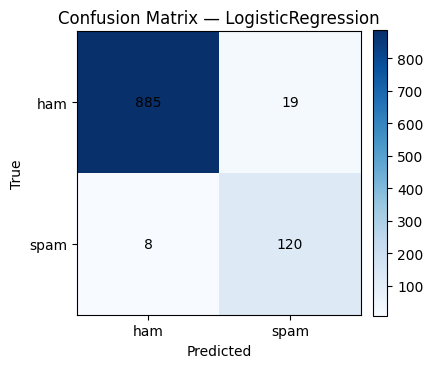


=== MultinomialNB ===
Accuracy: 0.958 | Precision(spam): 1.000 | Recall(spam): 0.664 | F1(spam): 0.798
              precision    recall  f1-score   support

         ham      0.955     1.000     0.977       904
        spam      1.000     0.664     0.798       128

    accuracy                          0.958      1032
   macro avg      0.977     0.832     0.887      1032
weighted avg      0.960     0.958     0.955      1032



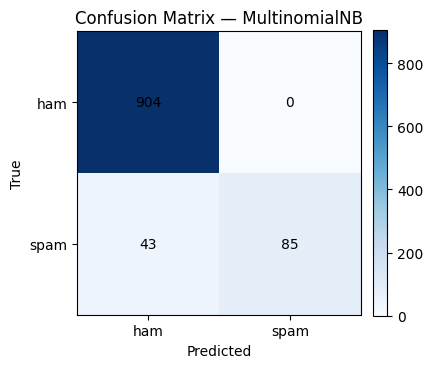


=== LinearSVM ===
Accuracy: 0.982 | Precision(spam): 0.936 | Recall(spam): 0.914 | F1(spam): 0.925
              precision    recall  f1-score   support

         ham      0.988     0.991     0.990       904
        spam      0.936     0.914     0.925       128

    accuracy                          0.982      1032
   macro avg      0.962     0.953     0.957      1032
weighted avg      0.981     0.982     0.981      1032



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


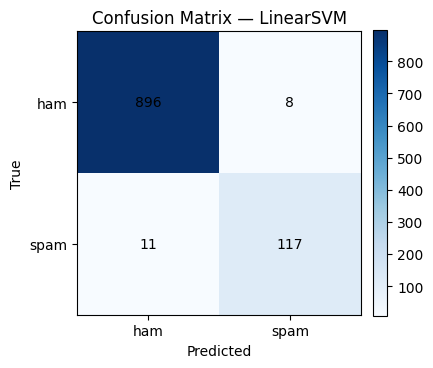


=== RandomForest ===
Accuracy: 0.982 | Precision(spam): 0.982 | Recall(spam): 0.867 | F1(spam): 0.921
              precision    recall  f1-score   support

         ham      0.982     0.998     0.990       904
        spam      0.982     0.867     0.921       128

    accuracy                          0.982      1032
   macro avg      0.982     0.932     0.955      1032
weighted avg      0.982     0.982     0.981      1032



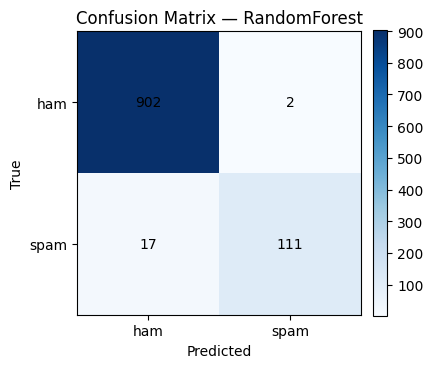

,model,accuracy,precision_spam,recall_spam,f1_spam
2,LinearSVM,0.981589,0.936000,0.914062,0.924901
3,RandomForest,0.981589,0.982301,0.867188,0.921162
0,LogisticRegression,0.973837,0.863309,0.937500,0.898876
1,MultinomialNB,0.958333,1.000000,0.664062,0.798122


In [9]:
def evaluate_model(name, clf, Xte, yte):
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        yte, preds, average="binary", pos_label="spam"
    )
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} | Precision(spam): {prec:.3f} | Recall(spam): {rec:.3f} | F1(spam): {f1:.3f}")
    print(classification_report(yte, preds, digits=3))

    # Confusion matrix
    cm = confusion_matrix(yte, preds, labels=["ham","spam"])
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["ham","spam"]); ax.set_yticklabels(["ham","spam"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    ax.set_title(f"Confusion Matrix — {name}")
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()

    return {"model": name, "accuracy": acc, "precision_spam": prec, "recall_spam": rec, "f1_spam": f1}

results = []
for name, clf in models.items():
    clf.fit(Xtr, y_train)
    results.append(evaluate_model(name, clf, Xte, y_test))

pd.DataFrame(results).sort_values(by=["f1_spam","recall_spam","accuracy"], ascending=False)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 0.25}

=== LinearSVM_Tuned ===
Accuracy: 0.983 | Precision(spam): 0.923 | Recall(spam): 0.938 | F1(spam): 0.930
              precision    recall  f1-score   support

         ham      0.991     0.989     0.990       904
        spam      0.923     0.938     0.930       128

    accuracy                          0.983      1032
   macro avg      0.957     0.963     0.960      1032
weighted avg      0.983     0.983     0.983      1032



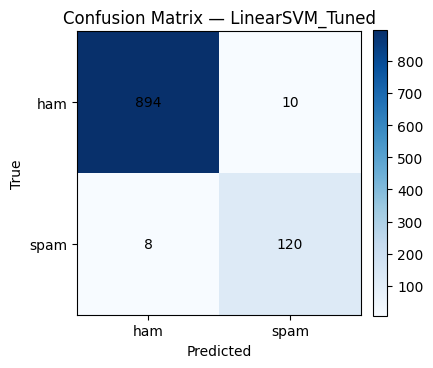

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "LinearSVM": {"C": [0.25, 0.5, 1.0, 2.0]},
    "LogisticRegression": {"C": [0.25, 0.5, 1.0, 2.0]}
}

best_name = "LinearSVM"  # or "LogisticRegression"
base = LinearSVC(class_weight="balanced") if best_name=="LinearSVM" else LogisticRegression(max_iter=2000, class_weight="balanced")

gscv = GridSearchCV(base, {"C": param_grid[best_name]["C"]}, cv=5, scoring="f1", n_jobs=-1)
gscv.fit(Xtr, y_train)
print("Best params:", gscv.best_params_)

best_clf = gscv.best_estimator_
_ = evaluate_model(f"{best_name}_Tuned", best_clf, Xte, y_test)


In [11]:
# Install imbalanced-learn if not already installed
!pip install -q imbalanced-learn

from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training set (important!)
smote = SMOTE(random_state=42)
Xtr_smote, ytr_smote = smote.fit_resample(Xtr, y_train)

print("Before SMOTE:", np.bincount(y_train.map({"ham":0,"spam":1})))
print("After SMOTE :", np.bincount(ytr_smote.map({"ham":0,"spam":1})))


Before SMOTE: [3612  514]
After SMOTE : [3612 3612]



=== LogisticRegression_SMOTE ===
Accuracy: 0.980 | Precision(spam): 0.908 | Recall(spam): 0.930 | F1(spam): 0.919
              precision    recall  f1-score   support

         ham      0.990     0.987     0.988       904
        spam      0.908     0.930     0.919       128

    accuracy                          0.980      1032
   macro avg      0.949     0.958     0.954      1032
weighted avg      0.980     0.980     0.980      1032



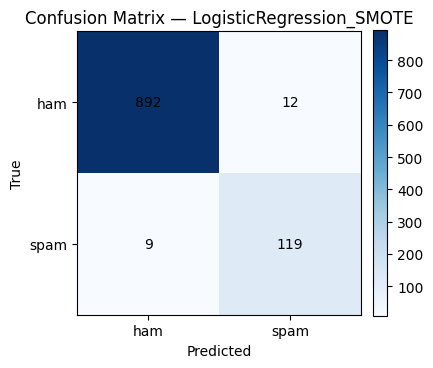


=== MultinomialNB_SMOTE ===
Accuracy: 0.970 | Precision(spam): 0.834 | Recall(spam): 0.945 | F1(spam): 0.886
              precision    recall  f1-score   support

         ham      0.992     0.973     0.983       904
        spam      0.834     0.945     0.886       128

    accuracy                          0.970      1032
   macro avg      0.913     0.959     0.935      1032
weighted avg      0.973     0.970     0.971      1032



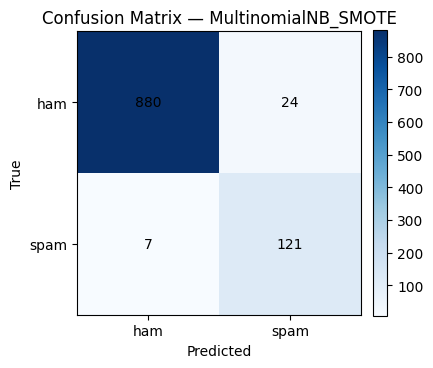


=== LinearSVM_SMOTE ===
Accuracy: 0.981 | Precision(spam): 0.935 | Recall(spam): 0.906 | F1(spam): 0.921
              precision    recall  f1-score   support

         ham      0.987     0.991     0.989       904
        spam      0.935     0.906     0.921       128

    accuracy                          0.981      1032
   macro avg      0.961     0.949     0.955      1032
weighted avg      0.980     0.981     0.980      1032



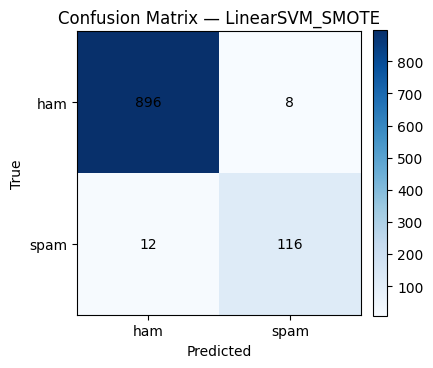


=== RandomForest_SMOTE ===
Accuracy: 0.984 | Precision(spam): 0.983 | Recall(spam): 0.891 | F1(spam): 0.934
              precision    recall  f1-score   support

         ham      0.985     0.998     0.991       904
        spam      0.983     0.891     0.934       128

    accuracy                          0.984      1032
   macro avg      0.984     0.944     0.963      1032
weighted avg      0.984     0.984     0.984      1032



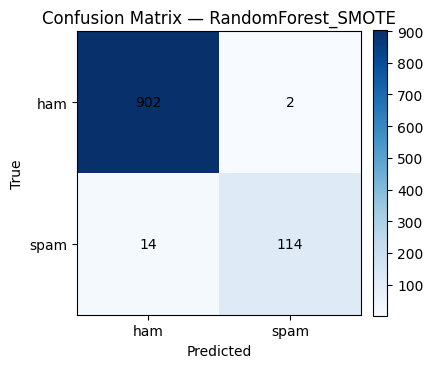

,model,accuracy,precision_spam,recall_spam,f1_spam
3,RandomForest_SMOTE,0.984496,0.982759,0.890625,0.934426
2,LinearSVM_SMOTE,0.980620,0.935484,0.906250,0.920635
0,LogisticRegression_SMOTE,0.979651,0.908397,0.929688,0.918919
1,MultinomialNB_SMOTE,0.969961,0.834483,0.945312,0.886447


In [12]:
results_smote = []
for name, clf in models.items():
    clf.fit(Xtr_smote, ytr_smote)
    results_smote.append(evaluate_model(f"{name}_SMOTE", clf, Xte, y_test))

df_results_smote = pd.DataFrame(results_smote).sort_values(
    by=["f1_spam","recall_spam","accuracy"], ascending=False
)
df_results_smote


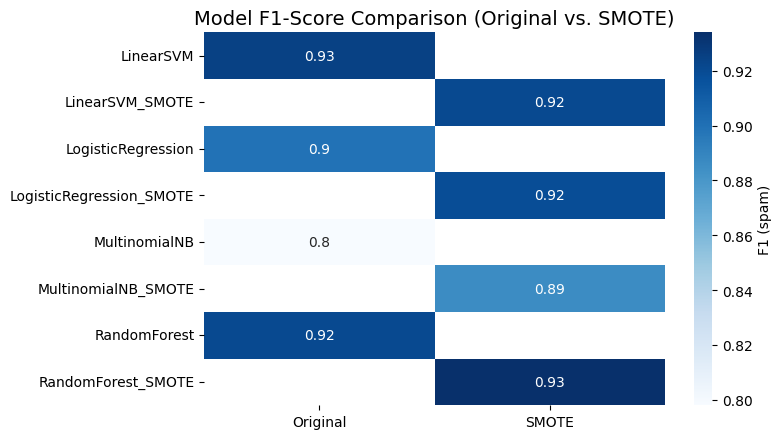

,model,accuracy,precision_spam,recall_spam,f1_spam,version
2,LinearSVM,0.982,0.936,0.914,0.925,Original
6,LinearSVM_SMOTE,0.981,0.935,0.906,0.921,SMOTE
0,LogisticRegression,0.974,0.863,0.938,0.899,Original
4,LogisticRegression_SMOTE,0.980,0.908,0.930,0.919,SMOTE
1,MultinomialNB,0.958,1.000,0.664,0.798,Original
5,MultinomialNB_SMOTE,0.970,0.834,0.945,0.886,SMOTE
3,RandomForest,0.982,0.982,0.867,0.921,Original
7,RandomForest_SMOTE,0.984,0.983,0.891,0.934,SMOTE


In [13]:
import seaborn as sns

# Combine results (original + SMOTE)
df_results = pd.DataFrame(results).assign(version="Original")
df_results_smote = pd.DataFrame(results_smote).assign(version="SMOTE")
df_all = pd.concat([df_results, df_results_smote], ignore_index=True)

# Round for display
for c in ["accuracy", "precision_spam", "recall_spam", "f1_spam"]:
    df_all[c] = df_all[c].round(3)

# --- FIX: make the matrix for the heatmap ---
# If there might be duplicate (model, version) rows, pivot_table is safer.
mat = df_all.pivot_table(
    index="model", columns="version", values="f1_spam", aggfunc="mean"
)
# (If you’re sure there are no duplicates, you could use:
# mat = df_all.pivot(index="model", columns="version", values="f1_spam")
# )

# Plot
plt.figure(figsize=(8, 4.5))
sns.heatmap(mat, annot=True, cmap="Blues", cbar_kws={"label": "F1 (spam)"})
plt.title("Model F1-Score Comparison (Original vs. SMOTE)", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Also show the full table and export for your report
display(df_all.sort_values(["model","version"]))
df_all.to_csv("model_comparison_original_vs_smote.csv", index=False)


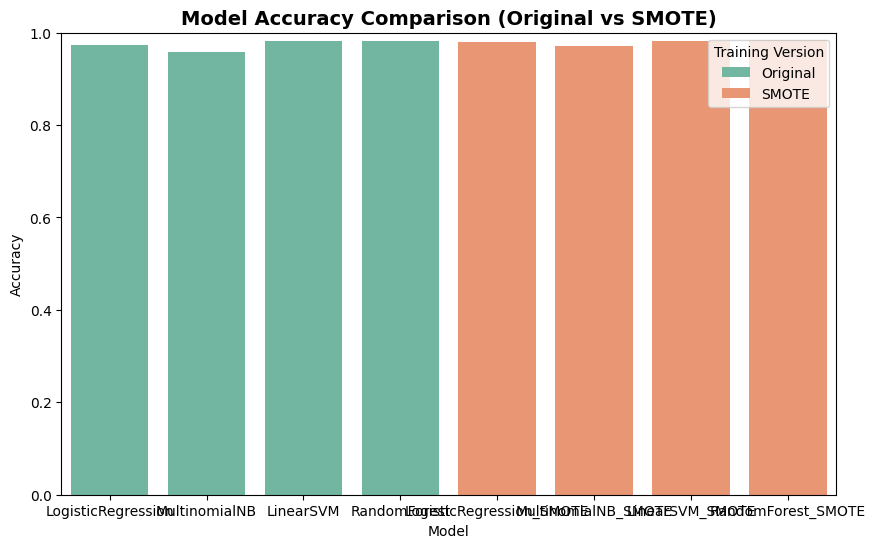

,model,version,accuracy
7,RandomForest_SMOTE,SMOTE,0.984
3,RandomForest,Original,0.982
2,LinearSVM,Original,0.982
6,LinearSVM_SMOTE,SMOTE,0.981
4,LogisticRegression_SMOTE,SMOTE,0.980
0,LogisticRegression,Original,0.974
5,MultinomialNB_SMOTE,SMOTE,0.970
1,MultinomialNB,Original,0.958


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine results (original + SMOTE) if not already done
df_results = pd.DataFrame(results).assign(version="Original")
df_results_smote = pd.DataFrame(results_smote).assign(version="SMOTE")
df_all = pd.concat([df_results, df_results_smote], ignore_index=True)

# Round values
df_all["accuracy"] = df_all["accuracy"].round(3)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_all,
    x="model", y="accuracy", hue="version",
    palette="Set2"
)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison (Original vs SMOTE)", fontsize=14, weight="bold")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Training Version")
plt.show()

# Show the table as well
df_all[["model","version","accuracy"]].sort_values(by="accuracy", ascending=False)


/tmp/ipython-input-3518042966.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="importance", y="feature", palette="viridis")


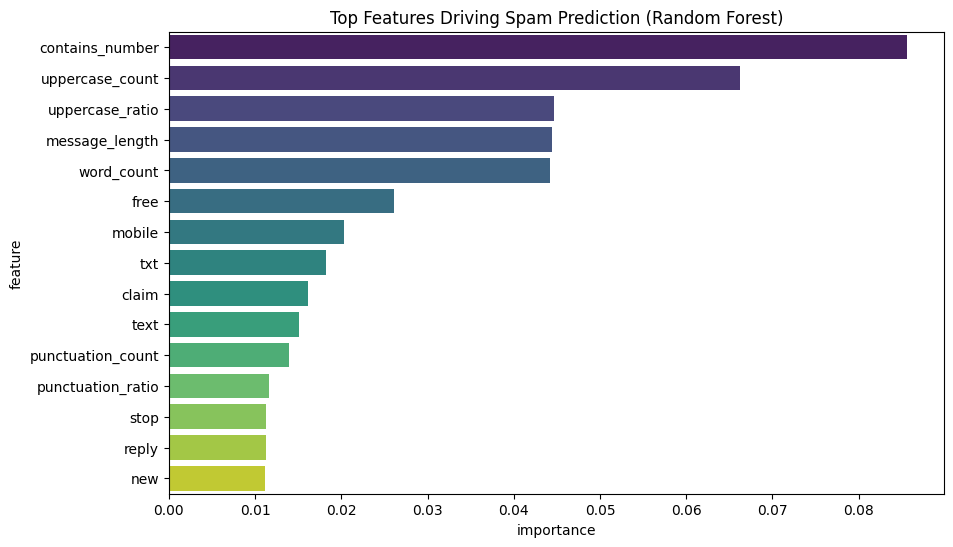

In [15]:
# After fitting RandomForest on SMOTE data
importances = models["RandomForest"].feature_importances_

# Match back to feature names
tfidf_feature_names = feature_builder.tfidf_vec.get_feature_names_out()
numeric_feature_names = num_feat.feature_names_
all_features = np.concatenate([tfidf_feature_names, numeric_feature_names])

feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
top_feats = feat_imp.sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_feats, x="importance", y="feature", palette="viridis")
plt.title("Top Features Driving Spam Prediction (Random Forest)")
plt.show()


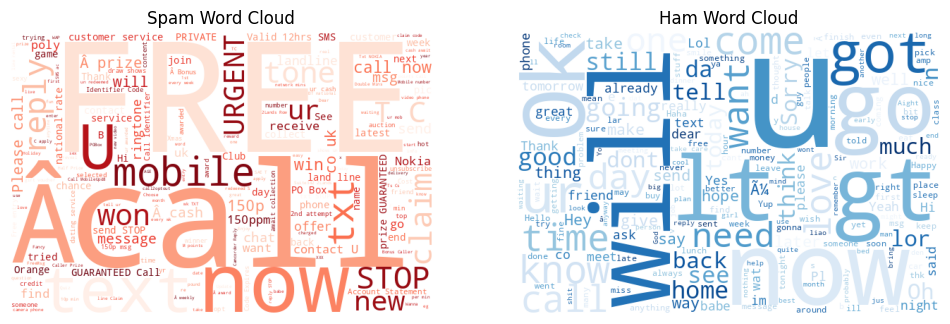

In [16]:
from wordcloud import WordCloud

spam_text = " ".join(df[df["label"]=="spam"]["message"])
ham_text  = " ".join(df[df["label"]=="ham"]["message"])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600,height=400,background_color="white", colormap="Reds").generate(spam_text))
plt.axis("off"); plt.title("Spam Word Cloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600,height=400,background_color="white", colormap="Blues").generate(ham_text))
plt.axis("off"); plt.title("Ham Word Cloud")
plt.show()


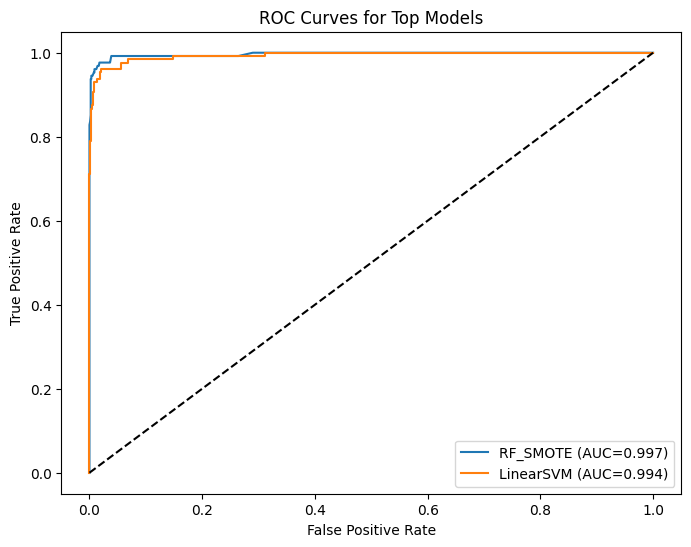

In [17]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, clf in [("RF_SMOTE", models["RandomForest"]), ("LinearSVM", models["LinearSVM"])]:
    # Need probability or decision_function
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(Xte)[:,1]
    else:
        y_scores = clf.decision_function(Xte)
    fpr, tpr, _ = roc_curve(y_test.map({"ham":0,"spam":1}), y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Top Models")
plt.legend()
plt.show()


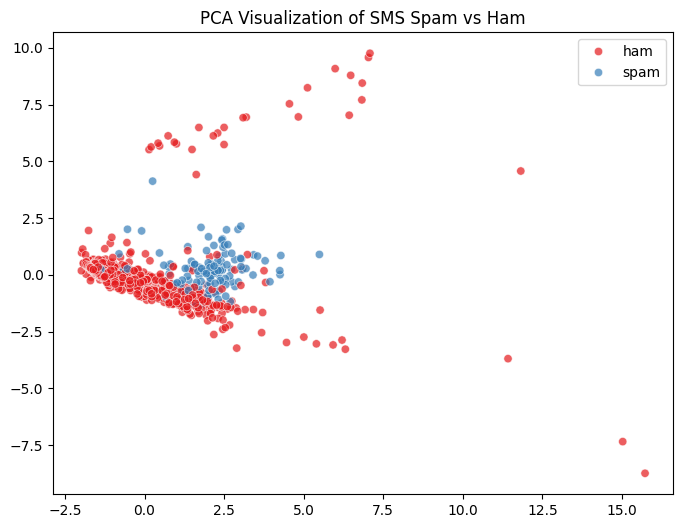

In [18]:
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=2).fit_transform(Xtr.toarray()[:1000])  # sample to keep light
labels = y_train[:1000].values

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=labels, alpha=0.7, palette="Set1")
plt.title("PCA Visualization of SMS Spam vs Ham")
plt.show()
